## MISTy pipeline on MIBI data
Run MISTy on nuclear measurements made on all fields in the multi-tissue array.

In [1]:
# MISTy
library(mistyR)
library(future)

# data manipulation
library(dplyr)
library(purrr)
library(distances)

# plotting
library(ggplot2)

plan(multisession)

mistyR is able to run computationally intensive functions
  in parallel. Please consider specifying a future::plan(). For example by running
  future::plan(future::multisession) before calling mistyR functions.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
library(readr)

## Load data tables

In [16]:
filepaths = list.files()
filepaths = filepaths[grep("marker_intensities_2023", filepaths)]

In [25]:
markers = lapply(filepaths, read_csv)

New names:
• `` -> `...1`
Rows: 1548 Columns: 43
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (43): ...1, ASCT2, ATP5A, CD14, CD163, CD20, CD31, CD36, CD3e, CD4, CD45...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1311 Columns: 43
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (43): ...1, ASCT2, ATP5A, CD14, CD163, CD20, CD31, CD36, CD3e, CD4, CD45...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 957 Columns: 43
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (43): ...1, ASCT2, ATP5A, CD14, CD163, CD20, CD31, CD36, CD3e, CD4, CD45...

ℹ Use `spec()` 

In [42]:
summary(markers)

      Length Class       Mode
 [1,] 43     spec_tbl_df list
 [2,] 43     spec_tbl_df list
 [3,] 43     spec_tbl_df list
 [4,] 43     spec_tbl_df list
 [5,] 43     spec_tbl_df list
 [6,] 43     spec_tbl_df list
 [7,] 43     spec_tbl_df list
 [8,] 43     spec_tbl_df list
 [9,] 43     spec_tbl_df list
[10,] 43     spec_tbl_df list
[11,] 43     spec_tbl_df list
[12,] 43     spec_tbl_df list
[13,] 43     spec_tbl_df list
[14,] 43     spec_tbl_df list
[15,] 43     spec_tbl_df list
[16,] 43     spec_tbl_df list
[17,] 43     spec_tbl_df list
[18,] 43     spec_tbl_df list
[19,] 43     spec_tbl_df list
[20,] 43     spec_tbl_df list
[21,] 43     spec_tbl_df list
[22,] 43     spec_tbl_df list
[23,] 43     spec_tbl_df list
[24,] 43     spec_tbl_df list
[25,] 43     spec_tbl_df list
[26,] 43     spec_tbl_df list
[27,] 43     spec_tbl_df list
[28,] 43     spec_tbl_df list

In [ ]:
# Display nuclei distribution
# Do we see B cell clusters?
for (i in 1:length(markers)) {
    m = markers[[i]]
    s = filepaths[i]
    # Note the coordinate mapping to get the correct orientation
    gp = ggplot(m, aes(x = y, y = -x, color = CD20)) +
      geom_point(size = 1) + coord_fixed() + 
      scale_color_viridis_c(option="magma", trans = "log1p") +
      theme_dark() + ggtitle(s)
    print(gp)
}

In [44]:
names(markers) = filepaths

In [51]:
result.folders <- markers %>% imap_chr(function(sample, name) {
    # Format marker table – for now no normalization
    # We drop CD36 has for some slides it's constantly 0
    sample.expr <- sample %>% select(-c(...1, x, y, CD36, MCT1, PDL1, SMA))
    # Extract position
    sample.pos <- sample %>% select(x, y)
  
    create_initial_view(sample.expr) %>% 
        add_juxtaview(sample.pos, neighbor.thr = 50) %>%
        add_paraview(sample.pos, l = 250, zoi = 50) %>%
        run_misty(results.folder = paste0("ResArray", .Platform$file.sep, name))
})


Computing triangulation


Generating juxtaview


Generating paraview


Training models

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD163”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD31”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD3e”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD4”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD45RO”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD56”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD8”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected an

In [52]:
misty.results <- collect_results(result.folders)
summary(misty.results)








Aggregating



                       Length Class  Mode
improvements           4      tbl_df list
contributions          4      tbl_df list
importances            5      tbl_df list
improvements.stats     5      tbl_df list
contributions.stats    6      tbl_df list
importances.aggregated 5      tbl_df list

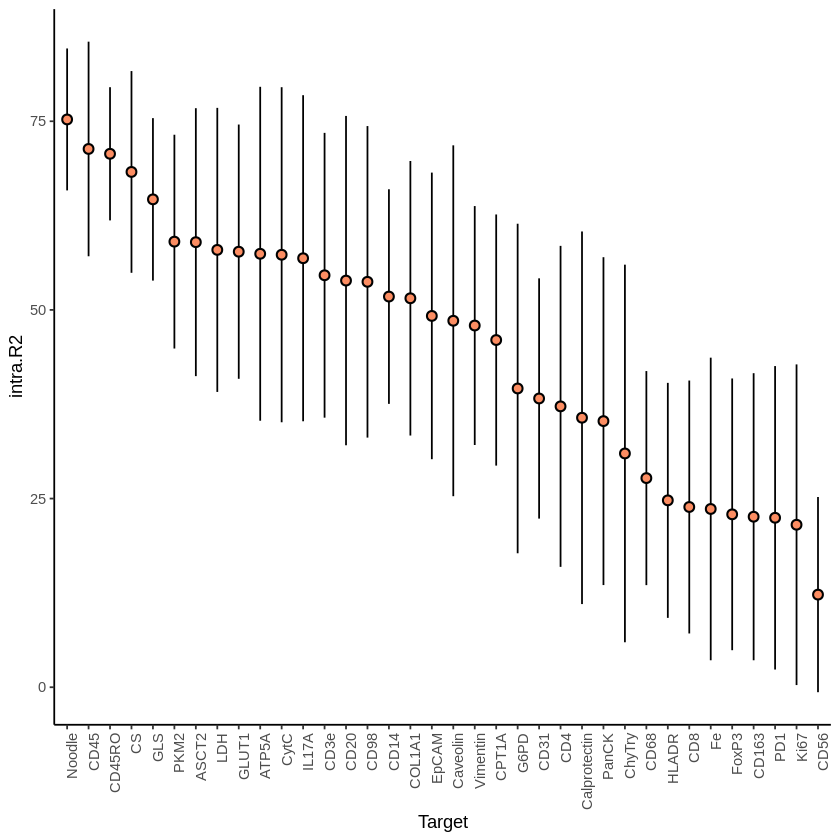

In [64]:
# Performance of intraview
misty.results %>%
  plot_improvement_stats("intra.R2")

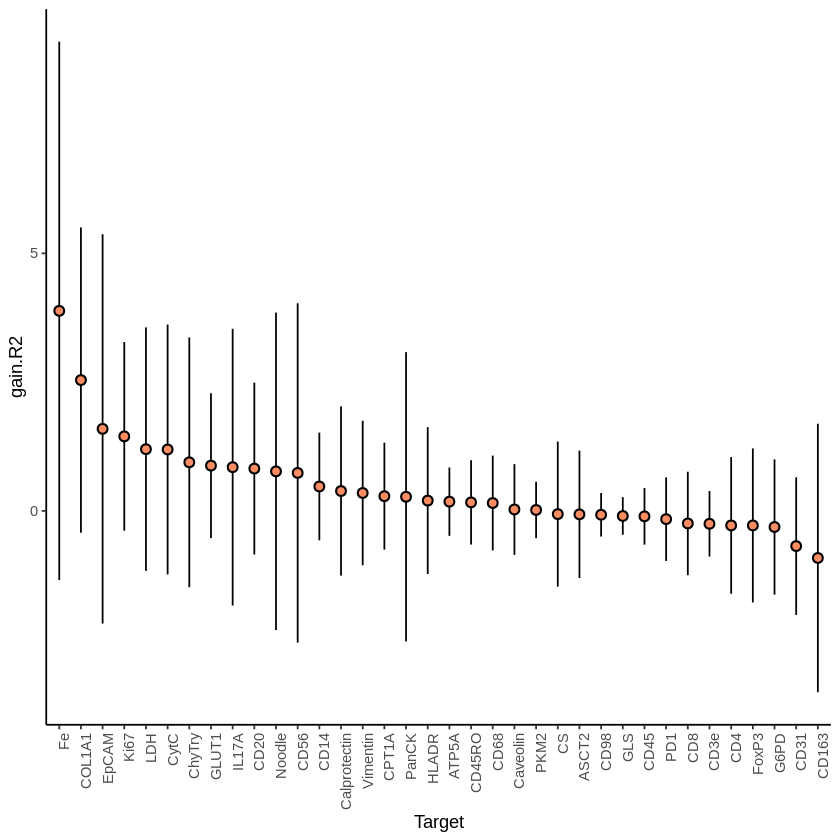

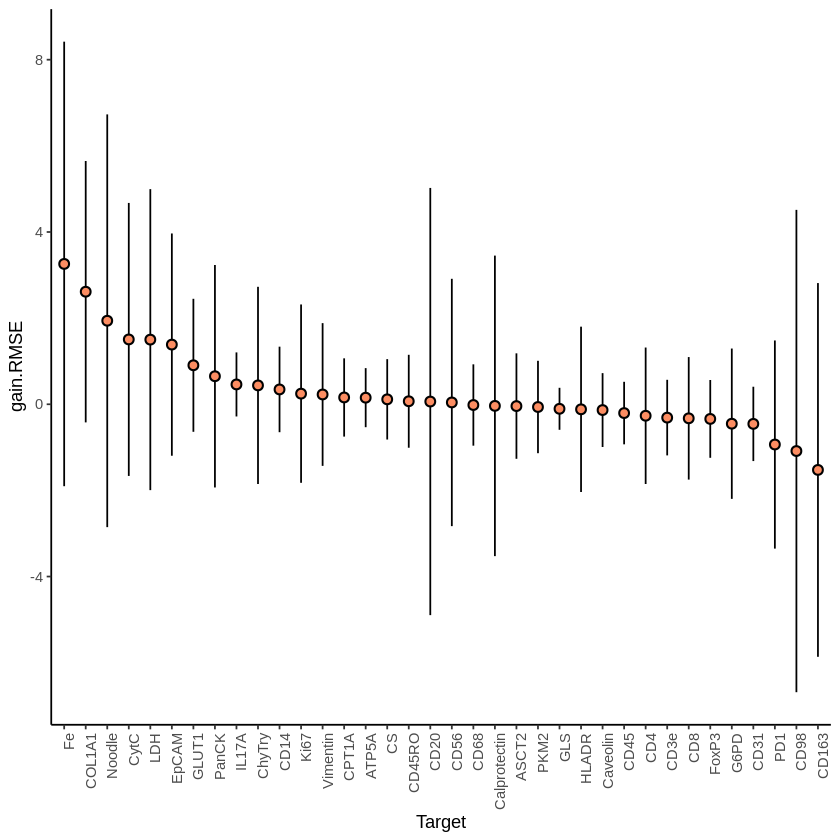

In [53]:
# Gain compared to intraview
misty.results %>%
  plot_improvement_stats("gain.R2") %>%
  plot_improvement_stats("gain.RMSE")

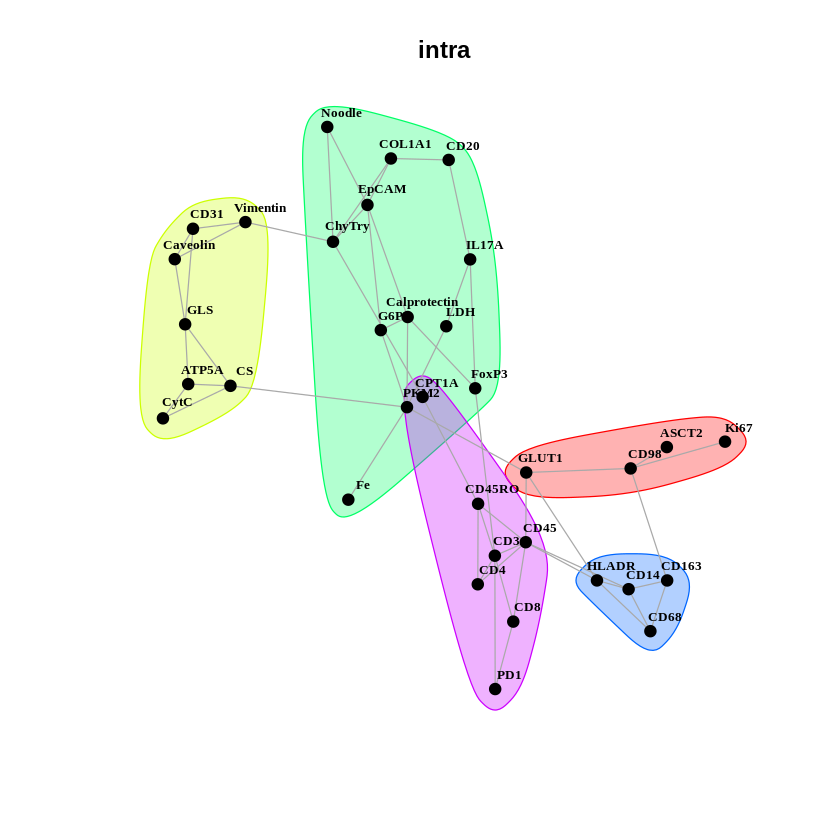

In [55]:
misty.results %>% plot_interaction_communities("intra")

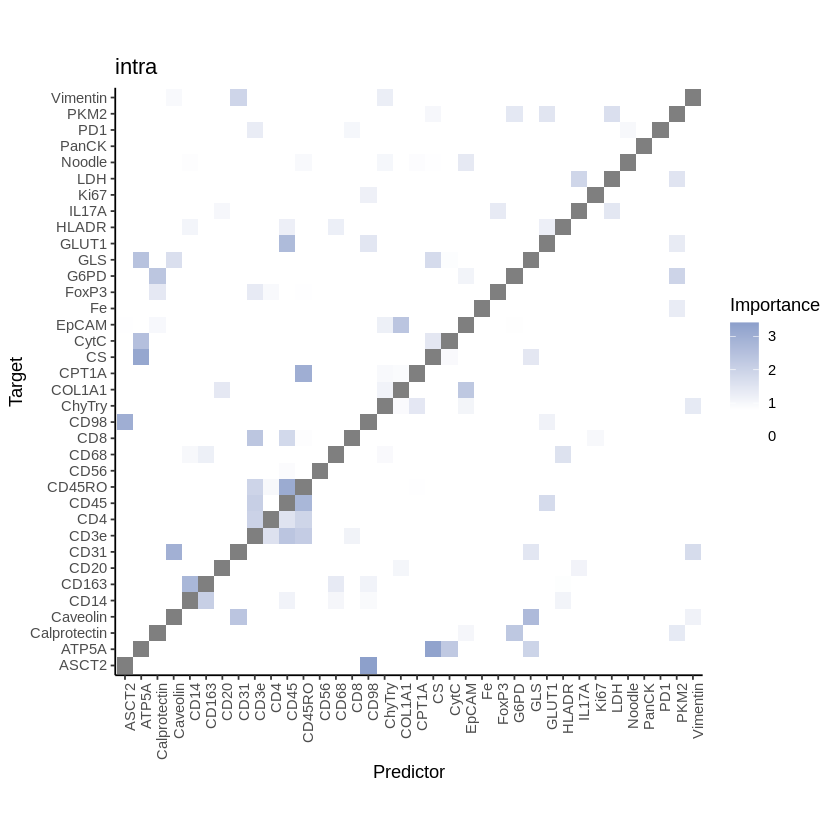

In [56]:
misty.results %>% plot_interaction_heatmap(view = "intra", cutoff = 0.8)

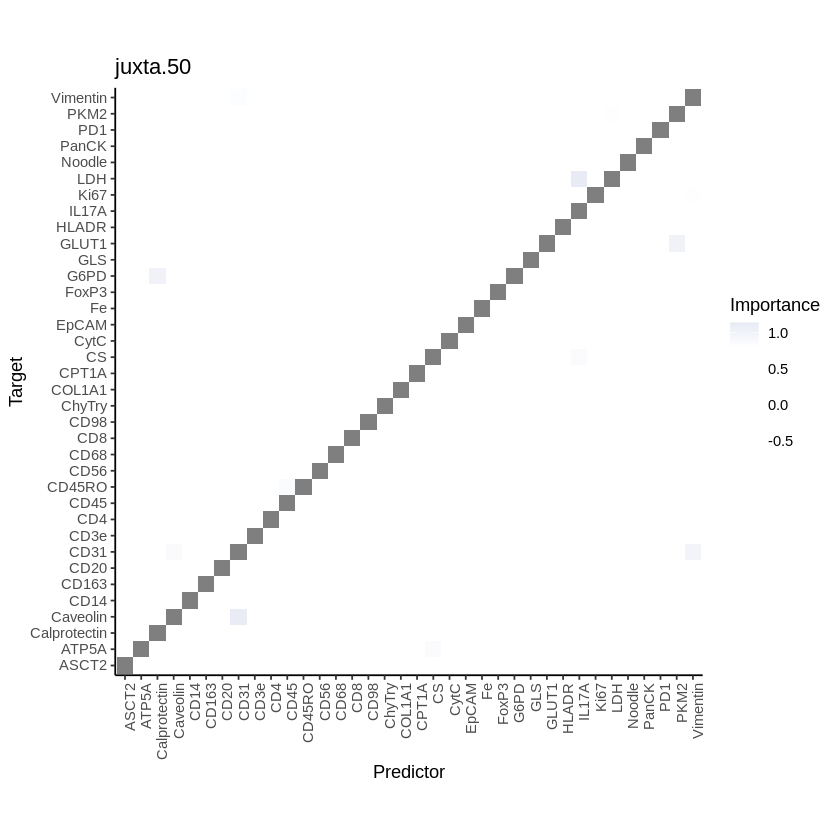

In [58]:
misty.results %>% plot_interaction_heatmap(view = "juxta.50", cutoff = 0.8)

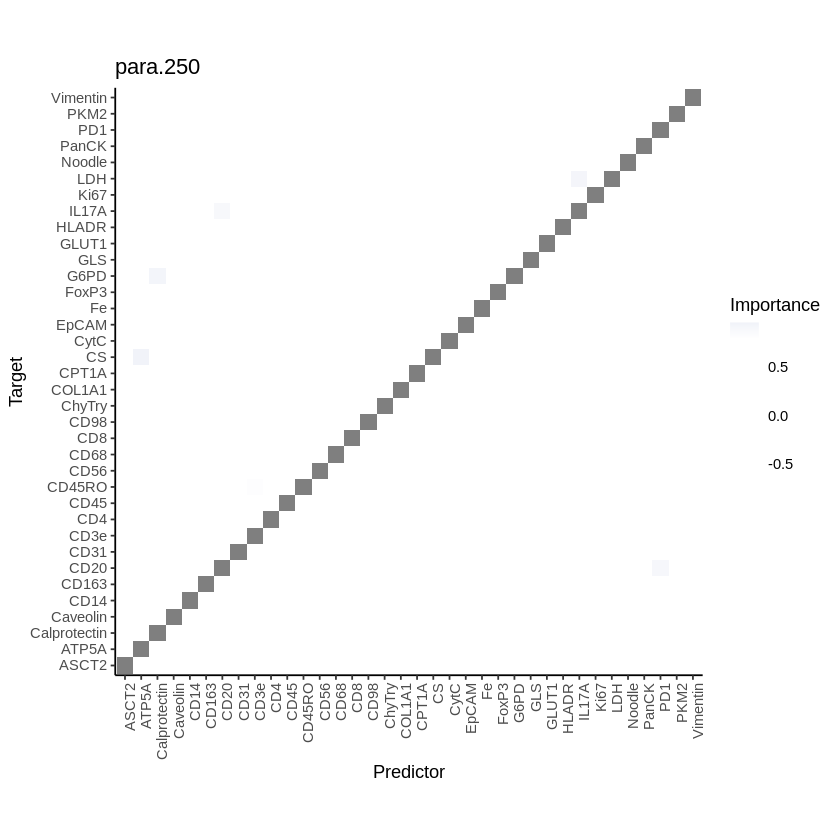

In [59]:
misty.results %>% plot_interaction_heatmap(view = "para.250", cutoff = 0.8)

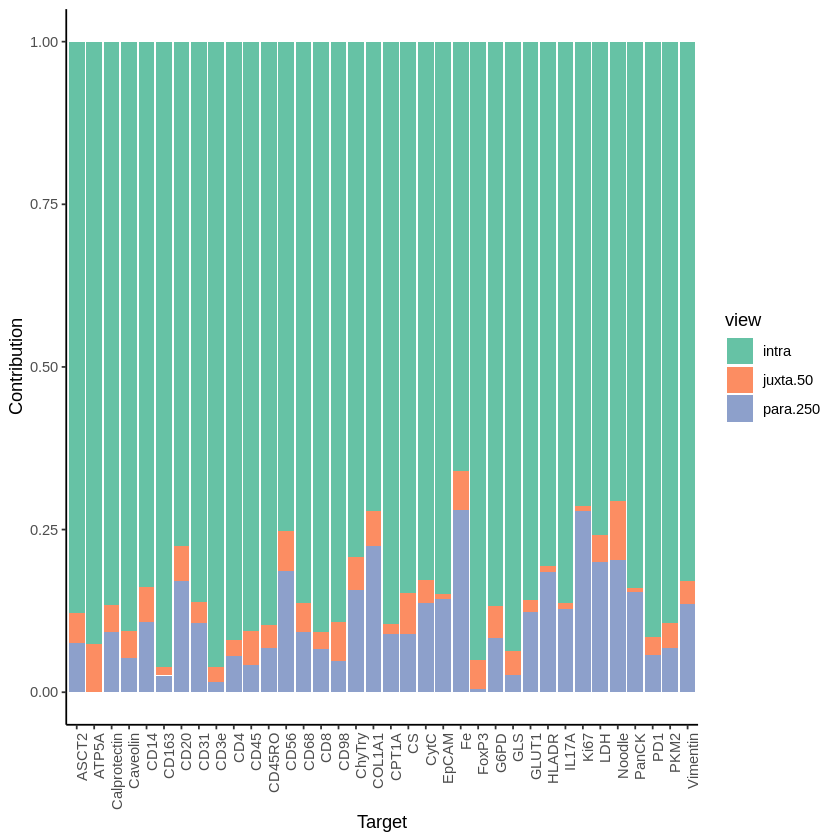

In [60]:
misty.results %>% plot_view_contributions()

Notes: 

* Try on whole cell segmentation
* Try on metabolic markers only